In [1]:
from brian2 import *
import numpy as np
%matplotlib inline

import matplotlib.style
import matplotlib as mlt
import matplotlib.pyplot as plt 
mlt.style.use('dark_background')

import elephant.statistics as stat
from elephant import kernels
from neo import SpikeTrain
import quantities 
from scipy.signal import chirp, spectrogramtoretore, find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from jupyterthemes import jtplot
jtplot.style()

from teili.core.groups import Neurons, Connections
from teili import TeiliNetwork
from teili.models.neuron_models import DPI as neuron_model
from teili.models.synapse_models import DPISyn as syn_model
from teili.models.parameters.dpi_neuron_param import parameters as neuron_model_param
prefs.codegen.target = "numpy"

from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'elephant'

### Utils

In [ ]:
def spike_rate(x, frame_len=0.3, frame_step=0.05, return_x=False):
    if len(x)<1:
        return np.array([])
    n_win = int((max(x) - frame_len) // frame_step)
    fr = np.zeros((n_win,))
    time_ax = np.zeros((n_win,))
    for i in range(n_win):
        l = x[(x >= i * frame_step) & (x < i * frame_step + frame_len)]
        fr[i] = len(l) / frame_len
        time_ax[i] = i * frame_step + frame_len
    if return_x:
        return fr, time_ax
    else:
        return fr

In [ ]:
tot = 10000
sec_signal = 2
max_sec = 10
t = np.linspace(0, max_sec, tot)
# w = chirp(t, f0=1, f1=100, t1=sec_signal, method='linear')
# # figure(figsize=(30, 5))
# # plt.plot(t, w)

In [ ]:
# #calculate the firing rate to test the peaks and the chirp
# peakind = find_peaks(w[:int((tot/max_sec)*sec_signal)]) # 1667/5 since there are 1667 samples per second and I'm interested only in the first 5s
# b = peakind[0]/(tot/max_sec) #1667 it's my sampling rate: 10000/10 
# train = SpikeTrain(b * quantities.s, t_stop= max(b)* quantities.s ) #create input for the network, with increasing frequency, the chirp is linear
# plt.plot(spike_rate(b), label='Input firing rate')
# # firing_rate = stat.instantaneous_rate(train, sampling_period = 0.1*quantities.s)
# # plt.plot(firing_rate)

In [2]:
duration = 4000
len_plateau = 2
freq=100
w = chirp(t, f0=1, f1=freq, t1=sec_signal, method='linear')
peakind = find_peaks(w[:int((tot/max_sec)*sec_signal)]) 
b = peakind[0]/(tot/max_sec) 
plateau = np.arange(sec_signal,sec_signal+len_plateau, 1/freq)
test_step = np.concatenate([b, plateau])
train = SpikeTrain(test_step * quantities.s, t_stop= max(test_step)* quantities.s ) 
indices = np.zeros(train.shape[0])
times = train*1000 * ms
input_spikegenerator = SpikeGeneratorGroup(1, indices, times)  

NameError: name 'chirp' is not defined

In [6]:
duration = 4000
len_plateau = 2
start_scope()

freq_range = [75, 150, 200]

mismatch_neuron_param = {
    'Iconst' : 0.1,
    'Ith' : 0.05,
    'Itau' : 0.05,
    }
mismatch_synap_param = {
    'baseweight': 0.1
    }

n_pop = 8
NeuInPop = 5
output_rates_per_run, output_rates, output_Imem, train_list = [],[],[],[]

for freq in freq_range:
    Net = TeiliNetwork()
    w = chirp(t, f0=1, f1=freq, t1=sec_signal, method='linear')
    peakind = find_peaks(w[:int((tot/max_sec)*sec_signal)]) 
    b = peakind[0]/(tot/max_sec) 
    plateau = np.arange(sec_signal,sec_signal+len_plateau, 1/freq)
    test_step = np.concatenate([b, plateau])
    train_list.append(test_step)
    train = SpikeTrain(test_step * quantities.s, t_stop= max(test_step)* quantities.s ) 
    indices = np.zeros(train.shape[0])
    times = train*1000 * ms
    input_spikegenerator = SpikeGeneratorGroup(1, indices, times)    

    MNg, input_synapse,  inh_synapses, spikemon_MNg,statemon_MNg  = [],[],[],[],[]

    for i in range(n_pop):
        MNg.append(Neurons(N=NeuInPop, equation_builder=neuron_model(num_inputs=10)))
        MNg[i].set_params(neuron_model_param)
        MNg[i].refP = 1 * ms
        MNg[i].Iath = 0.395 * nA
        MNg[i].Iahp = 0.001 * nA
        MNg[i].Ith = 0.77 * pA
        MNg[i].Iconst = 3 * nA
        MNg[i].add_mismatch(std_dict=mismatch_neuron_param, seed = 42)

    for i in range(n_pop):
        input_synapse.append(Connections(input_spikegenerator, MNg[i], equation_builder=syn_model()))
        input_synapse[i].connect(True)
        input_synapse[i].add_mismatch(std_dict=mismatch_synap_param, seed = 42)

    if 'Imem' in neuron_model().keywords['model']:
            input_synapse[0].weight = 900
            input_synapse[1].weight = 700
            input_synapse[2].weight = 500
            input_synapse[3].weight = 350
            input_synapse[4].weight = 300
            input_synapse[5].weight = 270
            input_synapse[6].weight = 250
            input_synapse[7].weight = 200
            
    
#     _inh_synapses = Connections(MNg[1], MNg[0], equation_builder=syn_model())
#     _inh_synapses.connect(True)
#     if 'Imem' in neuron_model().keywords['model']:
#         _inh_synapses.weight = -5000 
# add inhibitory connection from higher level neurons
    for syn in range(1, n_pop):
        inh_synapses_t = []
        for v in range(syn - 1, -1, -1):
            inh_synapses_t.append(Connections(MNg[syn], MNg[v], equation_builder=syn_model()))
            inh_synapses_t[-1].connect(True)
#             inh_synapses_t[v].add_mismatch(std_dict=mismatch_synap_param, seed = 42)
            if 'Imem' in neuron_model().keywords['model']:
                inh_synapses_t[-1].weight = -200 
#                 inh_synapses_t[v].I_tau = 0.5*pA 
        inh_synapses.append(inh_synapses_t)

        
    #Monitors
    spikemon_input = SpikeMonitor(input_spikegenerator)
    for m in range(n_pop):
        spikemon_MNg.append(SpikeMonitor(MNg[m]))

    statemon_input_synapse = StateMonitor(input_synapse[0], variables='I_syn',record=True)
#     statemon_inh_synapses = StateMonitor(inh_synapses, variables='I_inh',record=True)

    if 'Imem' in neuron_model().keywords['model']:
            for m in range(n_pop):
                statemon_MNg.append(StateMonitor(MNg[m], variables=["Imem"], record=[0]))

    Net.add(input_spikegenerator, MNg, input_synapse, spikemon_input, spikemon_MNg, 
            statemon_MNg, statemon_input_synapse, inh_synapses )


    Net.run(duration * ms)
    output_rates_per_run.append(spikemon_MNg)
    output_Imem.append(statemon_MNg)

NameError: name 'TeiliNetwork' is not defined

In [4]:
figure(figsize=(30, 5))
for p in range(n_pop):
    plot(output_Imem[0][p].t/ms, output_Imem[0][p].Imem.T/nA)
xlabel('time')
ylabel('I (nA)')
plt.legend()

IndexError: list index out of range

<Figure size 2160x360 with 0 Axes>

In [5]:
Pop_idx =[]
for rate_per_run in output_rates_per_run:
    N_pop = []
    for t in range(n_pop): 
        N = []
        for f in range(NeuInPop):
            temp=[]
            idx = where(rate_per_run[t].i == f)
            for i in range(len(idx[0])):
                temp.append(rate_per_run[t].t[idx[0][i]])
            N.append(temp)
        N_pop.append(N)
    Pop_idx.append(N_pop)

<Figure size 2160x360 with 0 Axes>

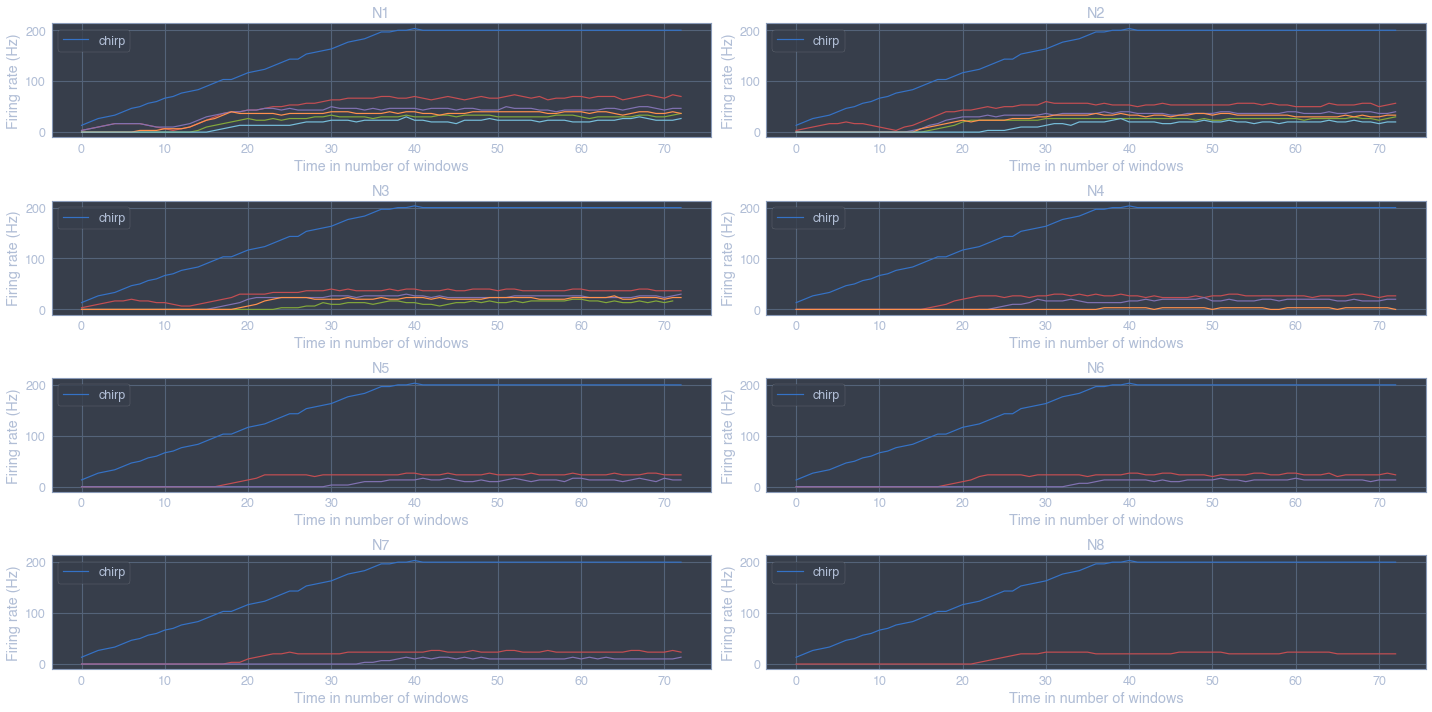

In [10]:
figure(figsize=(30, 5))
fig, ax = plt.subplots(4, 2, figsize=(20,10))
for pop in range(n_pop):
    _ax = ax[pop // 2][pop % 2]
    _ax.plot(spike_rate(np.asarray(train)), label='chirp')
    for _neu in Pop_idx[0][pop]:
        _ax.plot(spike_rate(np.array(_neu)))
    _ax.set_title('N{}'.format(pop + 1))
    _ax.set_xlabel('Time in number of windows')
    _ax.set_ylabel('Firing rate (Hz)');
    _ax.legend()
plt.tight_layout()

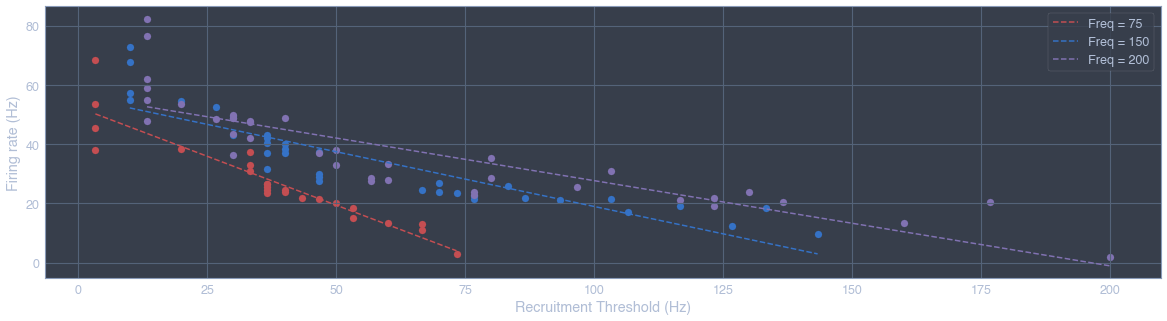

In [11]:
# chirp =np.asarray(train)
# fr, x = spike_rate(chirp, return_x=True)
plt.figure(figsize=(20, 5))

ifr_tot, fr_tot = [],[]
for h in range(len(freq_range)):
    ifr, fr2 = [],[]
    _, x = spike_rate(train_list[h], return_x=True)
    for f in range(n_pop):  
        frt_temp, ifrt_temp =[],[]
        for n in range(NeuInPop):
            if len(Pop_idx[h][f][n])<1:
                continue
            _idx = where(x > np.asarray(Pop_idx[h][f][n])[0])[0]
            if len(_idx) < 1:
                continue
            idx = _idx[0]
            ifrt_temp.append(spike_rate(train_list[h])[idx])
            _x = np.array(Pop_idx[h][f][n])
            frt_temp.append(len(_x[_x >= 2.])/len_plateau)
        ifr.append(ifrt_temp)
        fr2.append(frt_temp)
    ifr_tot.append(ifr)
    fr_tot.append(fr2)

x = np.concatenate(ifr_tot[0]).reshape((-1, 1))
y = np.concatenate(fr_tot[0]).reshape((-1, 1))
# plt.scatter(x, y, c=np.concatenate([i * np.ones((len(fr_tot[0][i]),)) for i in range(n_pop) if len(fr_tot[0][i]) > 0]), cmap='viridis', s=50)
plt.scatter(x, y, c='r', s=50)
x2 = np.concatenate(ifr_tot[1]).reshape((-1, 1))
y2 = np.concatenate(fr_tot[1]).reshape((-1, 1))
# plt.scatter(x2, y2, c=np.concatenate([i * np.ones((len(fr_tot[1][i]),)) for i in range(n_pop) if len(fr_tot[1][i]) > 0]), cmap='Greens', s=50)
plt.scatter(x2, y2, c='b', s=50)
x3 = np.concatenate(ifr_tot[2]).reshape((-1, 1))
y3 = np.concatenate(fr_tot[2]).reshape((-1, 1))
# plt.scatter(x3, y3, c=np.concatenate([i * np.ones((len(fr_tot[2][i]),)) for i in range(n_pop) if len(fr_tot[2][i]) > 0]), cmap='inferno', s=50)
plt.scatter(x3, y3, c='m', s=50)


lr = LinearRegression()
lr.fit(x, y)
a = lr.coef_[0][0]
b = lr.intercept_[0]
xx = np.array([min(x), max(x)])
plt.plot(xx, xx * a + b, '--r', linewidth=1.5, label='Freq = {}'.format(freq_range[0]))

lr = LinearRegression()
lr.fit(x2, y2)
a = lr.coef_[0][0]
b = lr.intercept_[0]
xx2 = np.array([min(x2), max(x2)])
plt.plot(xx2, xx2 * a + b, '--b', linewidth=1.5, label='Freq = {}'.format(freq_range[1]))

lr = LinearRegression()
lr.fit(x3, y3)
a = lr.coef_[0][0]
b = lr.intercept_[0]
xx3 = np.array([min(x3), max(x3)])
plt.plot(xx3, xx3 * a + b, '--m', linewidth=1.5, label='Freq = {}'.format(freq_range[2]))

xlabel('Recruitment Threshold (Hz)')
ylabel('Firing rate (Hz)');
plt.legend()